# Capstone Project: Stock Market Segmentation

# Part I. Definition

## Project Overview

Stocks are typically categorized by sectors, such as energy, financials, technology, healthcare etc, or by their market capitalization, such as S&P 500, S&P MidCap 400 or S&P SmallCap 600. Different segmentation methods will present different aspects of stock properties and behaviors. However, from time to time, stocks of different capitalization or sectors can have different growth rates (or decline rates) and volatility, creating a problem for investors who are looking for similar stocks based on their sectors or sizes.

The purpose of this project is to apply unsupervised learning to the stocks trading on NYSE and NASDAQ, and find an underlying clustering mechanism based on their financial conditions and growth rate. Such clustering mechanisms can present the stock market to investors from a different perspective, in which stocks exhibit similar financial conditions in each cluster, therefore, are likely to show similar performance. This new clustering mechanisms will also be compared to an existing mechanism such as grouping by sectors to test which methods yield better results based on the homogeneity of the stocks in each group. 

## Problem Statement

The goal of this project is to find more fundamental ways to group stocks, so that stocks in each group will exhibit similar financial standings and behavior. In order to find a stock segmentation scheme, there are two problems need to be addressed:

1. Identify relevant features to use for clustering
2. Find a clustering method based on the characteristics of the features

The strategy for solving these two problems will involve the following:

1. Retrieve NYSE and NASDAQ stock data from Yahoo Finance
2. Preliminary data exploration to understand the characteristics of the dataset
3. Data preprocessing including removing incomplete data and outliers and feature scaling
4. Apply Principal Component Analysis (PCA) to identify the most relevant feature combinations and visualize the dataset.
5. Apply unsupervised clustering algorithms including K-Means and Gaussian Mixture Model
6. Compare the performance of both models to existing segmentation methods based on their silhouette score


The final application of the project is to relabel all the stocks in the study based on their clusters, and offer a meaningful interpretation for each cluster.


## Metrics

Silhouette score is a common way to measure how closely are the data in each cluster are grouped. It is the average of the silhouette value of all the data point. The silhouette value a data point is calculated by:

s(i) = (b(i) - a(i))/max(a(i), b(i))

a(i): average dissimilarity of point i with respect to other data points in the same cluster  
b(i): minimum average dissimilarity of point i with respect to data points in another cluster

In this project, Euclidean distance will be used to measure dissimilarity because stocks with larger Euclidean distance are likely to be more different than those with smaller distance (or similar values of their features). The silhouette score will range between -1 to 1 by definition. The closer it is to 1, the better the clustering scheme, as the data points are more similar to the data of their own clusters than others. Conversely, the closer it is to -1, the poorer the clustering scheme.


# Part II. Analysis

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames
from scipy import stats

# Import supplementary visualizations code visuals.py (from Customer Segmentation Project with minor modifications)
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

## Data Exploration


In this project, stock financial statistics are retrieved from Yahoo Finance (**Footnote: Details of data retrieval can be found in Stock_Data_Retrieval.ipynb**). Although many features are available, only 8 of which are selected for this study. They are:

1. Price Earnings Ratio (PE)
2. Price Sales (PS)
3. Price Book (PB)
4. Short Ratio (SR)
5. Dividend Yield (DY)
6. Price Earning Growth Ratio (PEGR)
7. Percent Change from Year High (PCYH)
8. Percent Change from Year Low (PCYL)

Feature 1-6 will be based on the most recent quarter as of June 2nd, 2017; feature 7-8 will be based on the year to date data as of June 2nd, 2017. Out of over 4000 stocks listed on NYSE and NASDAQ, only 2869 stocks whose financial information is complete are chosen for this project. A sample dataset is presented below:


In [2]:
data_with_label = pd.read_csv("all_stock_data.csv", index_col=0)
label = data_with_label['SECTOR']
sample_indices = ['NVDA', 'JPM', 'ADES']
samples = pd.DataFrame(data_with_label.loc[sample_indices], columns = data_with_label.keys())
display(samples)

,DY,PB,PCYH,PCYL,PE,PEG,PS,SR,SECTOR
Symbol,,,,,,,,,
NVDA,0.41,13.42,-0.0237,2.1824,47.61,3.68,10.91,1.41,Technology
JPM,2.34,1.32,-0.0917,0.4962,13.14,1.58,3.29,2.13,Finance
ADES,0.00,2.46,-0.2278,0.5233,2.09,0.07,5.88,5.57,Basic Industries


The reason these features are chosen is that they are all ratios rather than absolute values, as absolute values may not represent a stock accurately. For example, a stock with a lower price is not necessarily cheaper than a stock with a higher price. The value of a stock is more accurately represented by their PE or PB ratios. Although there are many features that are ratios, only the 8 are chosen because they are widely available and commonly used to evaluate stocks. Of these 8 features, Feature PE, PS, PB, DY and PEGR offer a financial perspective of a stock, Feature SR a trading perspective, and Feature PCYH and PCYL a growth perspective.

## Exploratory Visualization

A summary of the dataset is provided below:

In [3]:
display(data_with_label.describe())

,DY,PB,PCYH,PCYL,PE,PEG,PS,SR
count,2869.000000,2869.000000,2869.000000,2869.000000,2869.000000,2869.000000,2869.000000,2869.000000
mean,1.923789,5.262124,-0.137261,1.036934,50.919360,4.647964,3.663936,5.036375
std,2.590263,32.518166,0.131984,33.707553,219.507561,140.381934,14.516095,5.342447
min,0.000000,0.070700,-0.942500,0.000000,0.075000,-4098.680000,0.010000,0.000000
25%,0.000000,1.360000,-0.188500,0.173100,15.500000,0.000000,1.010000,1.830000
50%,1.250000,2.130000,-0.103400,0.315600,21.670000,1.300000,2.250000,3.470000
75%,2.720000,3.760000,-0.041500,0.518400,34.030000,2.290000,4.192800,6.510000
max,35.740000,1191.530000,0.295000,1805.749800,6385.000000,4299.500000,529.420000,58.350000


According to the summary statistics, there are a few observations:

1. Most features have extreme values that are far above or below their 25, 50 and 75 percentiles, which can cause inaccurate clustering.
2. PCYH is negative whereas all other features are positive. PCYH should be negative by definition. Any positive PCYH should be removed.
3. Some features (such as PE, PEG) have a larger range and variability than other features (such as PCYH, PCYL) by the way they are defined. Rescale these features to similar range will help PCA identify more important dimensions.

In addition to the summary table, a histogram of each feature is show below:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000A5FB978>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000000B43D390>]], dtype=object)

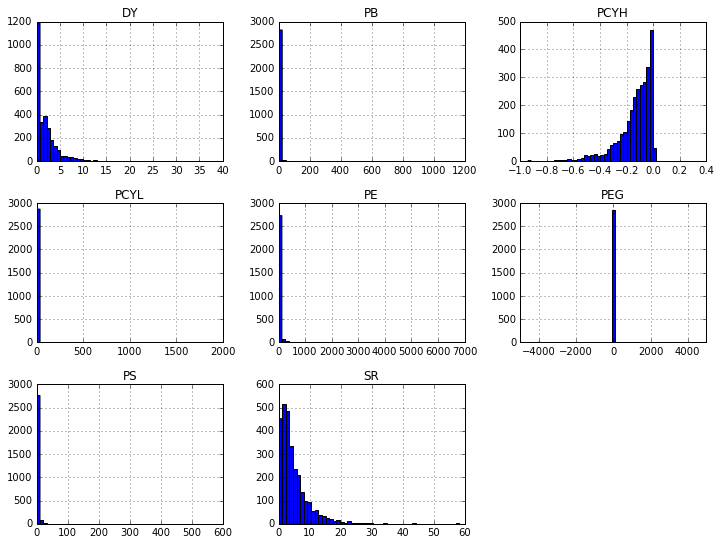

In [4]:
pd.DataFrame.hist(data_with_label, bins=50, figsize=(12, 9))

As shown in the histogram plots, outliers have heavily skewed the distributions and need to be removed to allow a closer visualization of the distribution. 

## Algorithms and Techniques

As features might correlate with each other, some features might be more relevant than others. Feature relevance can be determined based on how well can they be predicted from other features. The feature that can be well predicted is less relevant as its information is already contained in other features. A linear regressor, a decision tree regressor and a SVM regressor will be used for prediction and R score will be used for measuring feature relevance. The higher the R score, the less relevant the feature is. 

Once feature relevance is determined, PCA can be used to compress the dataset to lower dimensions, allowing to visualize the dataset as well as identify the most relevant features or feature combinations that can explain the most variation of the dataset. However, such features or feature combinations might not exist. In other words, PCA might fail to reduce the dimensionality of the dataset while reasonably keeping their variation. 

If the PCA succeeds, K-Means and Gaussian Mixture clustering algorithms will be applied to the reduced dataset. Otherwise, they will be applied to the original dataset. These two unsupervised learning algorithms will cluster the data points into several groups. The number of groups can be determined by the one with highest silhouette scores. The clustering models will then be compared to the benchmark model and might offer fresh and meaningful perspectives to understand the stock market.

## Benchmark

The benchmark model for this project is to group stocks by their sectors, which is a common and natural way to group stock. There are 11 sectors in the dataset such as Finance, Consumer Service, Technology etc. We can calculate the silhouette score of this group scheme and compared it to the clustering models. The benchmark result will be calculated in later sections, after the data has been preprocessed.

# Part III. Methodology

## Data Preprocessing



Based on the observations from Data Exploration and Visualization, there are a few steps needed to preprocess it:

1. Drop any duplicate data points.  
2. Remove outliers based on the inter-quartile range (IQR). Typically for normally distributed data, 1.5 times the IQR above 75 percentiles or below 25 percentiles will be used as cut offs for outliers. However, due to the skewness of this dataset, a more tolerant range will be used.  
3. Remove data points with positive PCYH, and take the absolute value of PCYH to convert them all to positive for consistency with PCYL.  
4. Scale the features to range 0 to 1.


In [5]:
# Remove outlier based on inter-quartile range. Default is 1.5 IQR.
def remove_outlier(data_frame, r=1.5):
    result = data_frame.copy()
    data1 = np.array(result)
    m, n = data1.shape
    iqr = stats.iqr(data1, axis=0)
    p25, p75 = np.percentile(data1, 25, axis=0), np.percentile(data1, 75, axis=0)
    thd_l, thd_h = (p25-r*iqr).reshape((-1, n)), (p75+r*iqr).reshape((-1, n))
    flag = np.logical_and(data1>thd_l, data1<thd_h).all(axis=1)
    return result[flag]

In [6]:
## Data Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Remove sector label
data = data_with_label.drop('SECTOR', 1)

# Remove duplicated rows
data.drop_duplicates(keep=False, inplace=True)
# Remove outliers based on inter-quartile range
data = remove_outlier(data, 10)

# Drop rows with positive 'PCYH', then convert all 'PCYH' to positive
data = data.loc[data['PCYH']<0]
data['PCYH'] = data['PCYH'].abs()

# Feature Scaling
MMS = MinMaxScaler()
data_scale = MMS.fit_transform(data)
data = pd.DataFrame(data_scale, index=data.index, columns=data.columns)
display(data.describe())


,DY,PB,PCYH,PCYL,PE,PEG,PS,SR
count,2674.000000,2674.000000,2674.000000,2674.000000,2674.000000,2674.000000,2674.000000,2674.000000
mean,0.100765,0.115432,0.146516,0.106703,0.135142,0.486524,0.085996,0.095996
std,0.130037,0.120168,0.138981,0.094089,0.129229,0.061703,0.087501,0.099092
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.047552,0.045522,0.046486,0.069218,0.450791,0.028106,0.035272
50%,0.068002,0.075228,0.111312,0.084872,0.096552,0.479679,0.061973,0.066349
75%,0.142857,0.135133,0.200419,0.138455,0.145927,0.500165,0.114882,0.124309
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
samples = pd.DataFrame(data.loc[sample_indices], columns = data.keys())
display(samples)

,DY,PB,PCYH,PCYL,PE,PEG,PS,SR
Symbol,,,,,,,,
NVDA,0.021613,0.499800,0.025042,0.588296,0.217826,0.531634,0.306352,0.026883
JPM,0.123353,0.046774,0.097199,0.133757,0.059869,0.485501,0.092187,0.040610
ADES,0.000000,0.089456,0.241617,0.141063,0.009234,0.452329,0.164980,0.106196


The preprocessed data statistics is summarized in the table above, and a matrix scatter plot of any two features is shown in the figure below, with a histogram of each feature on the diagonal. Since the data has excluded outliers and scaled, their distribution can be clearly visualized, and they are all unimodal distribution skewed to the right. The scatter plots don't show strong linear relationship between any two features. Nevertheless, some features are clearly inversely related such as DY and SR. This is consistent with intuition as stocks with higher dividend yield are less likely to be shorted becuase they are making great profit, and vice versa.

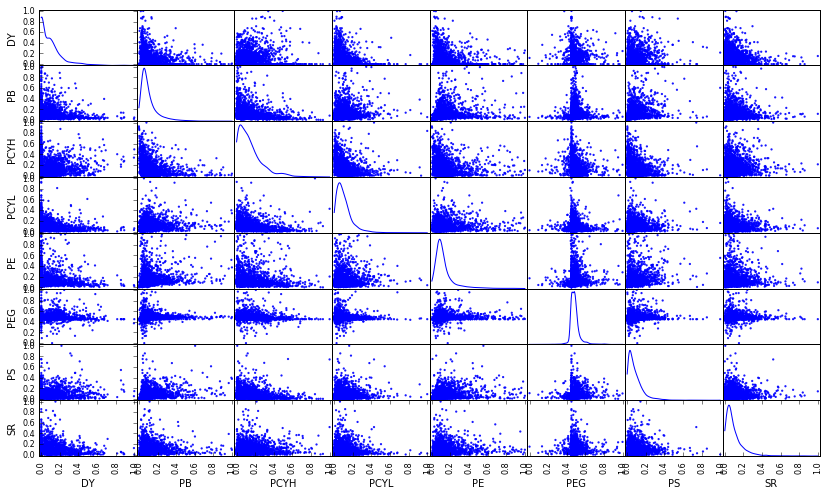

In [8]:
# Produce a scatter matrix for each pair of features in the data
pd.plotting.scatter_matrix(data, alpha = 0.9, figsize = (14,8), diagonal = 'kde');

## Implementation

The implementation process can be broken down in to three parts: Feature Relevance, PCA, Clustering.

### Part 1: Feature Relevance

**1.** Feature Relevance Study:
* Drop a feature from the dataset for later use of other features to predict its value
* Split the dataset into training and test set
* Train a regressor (Linear Regressor, Decision Tree, SVR) on the training set
* Predict the value of the test set
* Calculate the coefficient of determination

In [9]:
# Compute the predictability (R_Score) of each feature using other features
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression as LR
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.svm import SVR

def R_Score(data, reg):
    r_score_dic = {}
    feature_list = data.columns.values
    for feature in feature_list:
        new_data = data.drop(feature, axis=1)
        new_label = data[feature]
        X_train, X_test, y_train, y_test = train_test_split(new_data, new_label, test_size=0.10, random_state=13)
        regressor = reg
        regressor.fit(X_train, y_train)
        score = regressor.score(X_test, y_test)
        r_score_dic[feature] = score
    return r_score_dic

def feature_relevance(data, reg_list, reg_names):
    Result = pd.DataFrame(columns=reg_names, index=data.columns.values)
    for i in range(len(reg_list)):
        r_score_dic = R_Score(data, reg_list[i])
        for keys in r_score_dic.keys():
            Result.loc[keys, reg_names[i]] = r_score_dic[keys]
    return Result

reg1 = LR()
reg2 = DTR()
reg3 = SVR()
reg_list = [reg1, reg2, reg3]
reg_names = ['Linear Regression', 'Decision Tree', 'SVR']
all_r_scores = feature_relevance(data, reg_list, reg_names)

display(all_r_scores)

,Linear Regression,Decision Tree,SVR
DY,0.0717958,-0.450468,0.0597555
PB,0.158387,-0.506371,0.103447
PCYH,0.100279,-0.303527,0.148848
PCYL,0.0581436,-0.481599,0.0150209
PE,0.147818,-0.249109,0.124602
PEG,0.0398144,-0.871992,-0.166757
PS,0.222831,-0.808908,0.081005
SR,-0.0319298,-1.06239,-0.097128


Observation from feature relevance analysis:

From the result of regression analysis, the linear regressor slightly outperforms decision tree and SVR (with a rbf kernel) regressors. However, the highest coefficient of determination is 0.223 when predicting Price to Sales using linear regression, meaning only 22.3% of the variation in PS can be predicted by other features. This result is consistent with Figure ??, where no two features exhibit strong relationship.

### Part 2: PCA

**2.** Principal Component Analysis (PCA)
* Apply PCA to the data set and identify the composition of principal axes.
* Reduce the dataset into 2 dimensions for visualization.

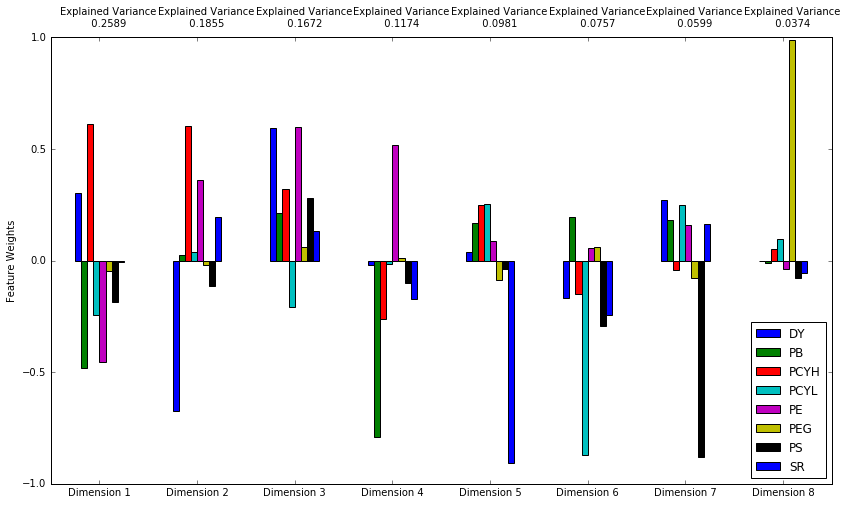

In [10]:
from sklearn.decomposition import PCA

good_data = data
pca = PCA(n_components=8)
pca.fit(data)
pca_samples = pca.transform(samples)
pca_results = vs.pca_results(data, pca)

Overservation from PCA:

to  
be  
written  



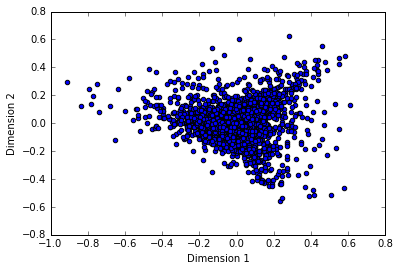

In [11]:
# Reduce dataset to 2 dimensions for visulization
pca = PCA(n_components=2)
pca.fit(good_data)
reduced_data = pca.transform(good_data)
pca_samples = pca.transform(samples)
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])
reduced_data.plot(x='Dimension 1', y='Dimension 2', kind='scatter')

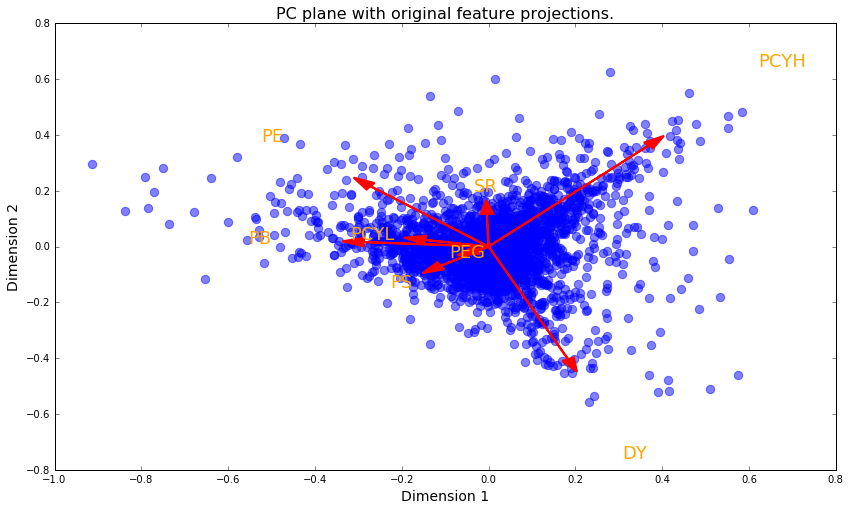

In [12]:
# Create a biplot
vs.biplot(good_data, reduced_data, pca)

### Part 3: Clustering

**3.** Clustering study
* Apply Gaussian Mixture and K-Means clustering algorithms to the reduced dataset for visulization
* Apply Gaussian Mixture and K-Means clusteirng algorithms to the orignal dataset

In [13]:
# Gaussian Mixture Clustering

from sklearn import mixture
from sklearn.metrics import silhouette_score as sc

clusterer1 = mixture.GMM(n_components=3, covariance_type='diag', random_state=0).fit(reduced_data)
preds1 = clusterer1.predict(reduced_data)
centers1 = clusterer1.means_
sample_preds1 = clusterer1.predict(pca_samples)

score1 = sc(reduced_data, preds1)
print score1
print centers1

0.418501757356
[[-0.11384492  0.07446457]
 [-0.01094713 -0.02392522]
 [ 0.17598402  0.02029689]]


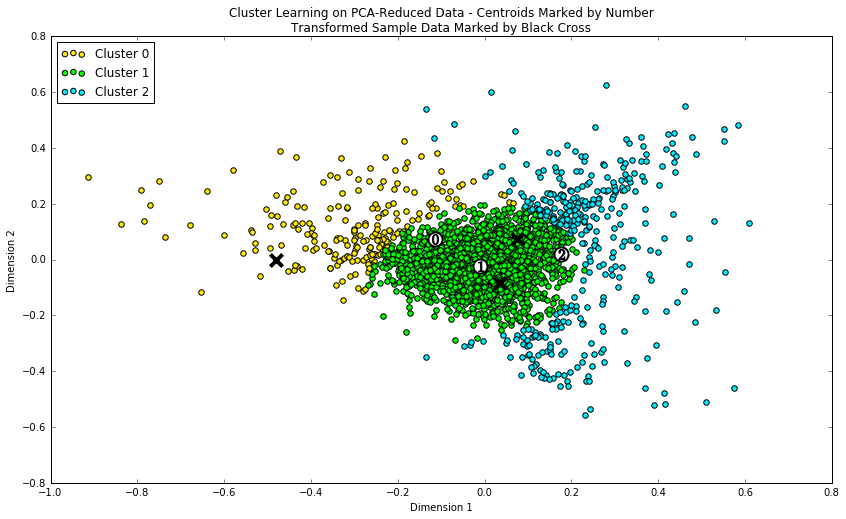

In [14]:
# Display the results of the clustering from implementation
vs.cluster_results(reduced_data, preds1, centers1, pca_samples)

In [16]:
# Use KMeans Clustering
from sklearn.cluster import KMeans

clusterer2 = KMeans(n_clusters=3, random_state=0).fit(reduced_data)
preds2 = clusterer2.predict(reduced_data)
centers2 = clusterer2.cluster_centers_
sample_preds2 = clusterer2.predict(pca_samples)
score2 = sc(reduced_data, preds2)
print score2
print centers2

0.360048563621
[[-0.19314195  0.03715067]
 [ 0.02822923 -0.07356867]
 [ 0.15703176  0.15104433]]


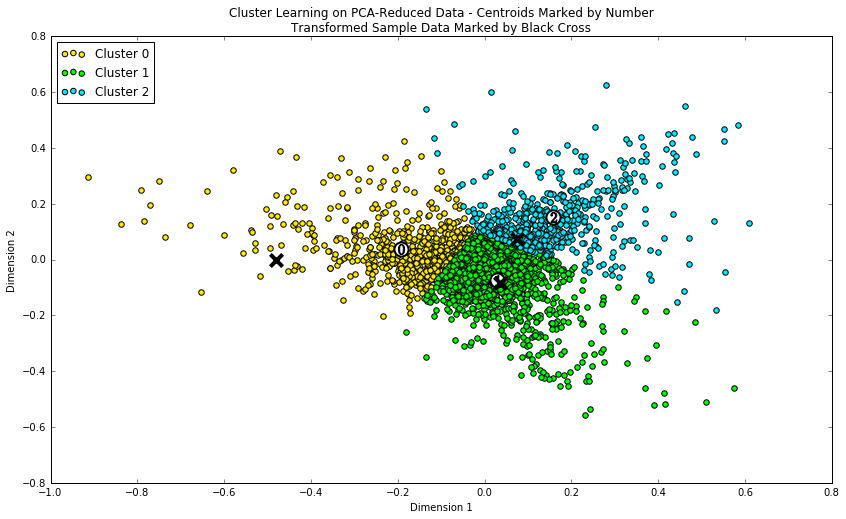

In [17]:
# Display the results of the clustering from implementation
vs.cluster_results(reduced_data, preds2, centers2, pca_samples)

## Refinement

Both the Gaussian Mixture and KMeans models can be refined by finding the optimal number of groups, which can be determined by their silhouette score. Silhouette scores of 2-8 clusters are calculated based on the clustering results of the reduced dataset and the original dataset, and are shown in the following table.

In [18]:
def sil_score(data, n_clusters):
    result = pd.DataFrame(columns=['Gaussian', 'KMeans'], index=range(2, n_clusters+1))
    for i in range(2, n_clusters+1):
        cluster1 = mixture.GMM(n_components=i, covariance_type='diag', random_state=0).fit(data)
        preds1 = cluster1.predict(data)
        centers1 = cluster1.means_
        score1 = sc(data, preds1)
        result.loc[i, 'Gaussian'] = score1
        
        cluster2 = KMeans(n_clusters=i, random_state=0).fit(data)
        preds2 = cluster2.predict(data)
        centers2 = cluster2.cluster_centers_
        score2 = sc(data, preds2)
        result.loc[i, 'KMeans'] = score2
    return result

s_score_reduced = sil_score(reduced_data, 12)
s_score_original = sil_score(data, 12)
display(s_score_reduced)
display(s_score_original)

,Gaussian,KMeans
2,0.434996,0.296553
3,0.418502,0.360049
4,0.41732,0.377182
5,0.299274,0.330167
6,0.323783,0.340036
7,0.267156,0.333623
8,0.265113,0.329107
9,0.228124,0.330025
10,0.241844,0.323698
11,0.21597,0.333508


,Gaussian,KMeans
2,0.27355,0.178597
3,0.259704,0.245855
4,0.224418,0.244823
5,0.205997,0.258772
6,0.208458,0.235581
7,0.191856,0.175612
8,0.176999,0.161851
9,0.194504,0.165408
10,0.143184,0.160886
11,0.131552,0.157912


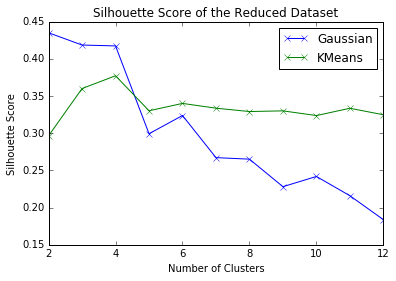

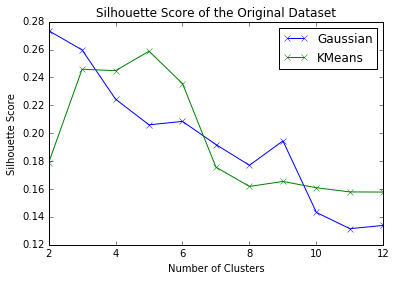

In [19]:
ax1 = s_score_reduced.plot(marker='x', title='Silhouette Score of the Reduced Dataset')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Silhouette Score')


ax2 = s_score_original.plot(marker='x', title='Silhouette Score of the Original Dataset')
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('Silhouette Score')

# Part IV. Results

## Model Evaluation and Validation

In [24]:
# Final Model

clusterer3 = mixture.GMM(n_components=2, covariance_type='diag', random_state=0).fit(data)
preds3 = clusterer3.predict(data)
centers3 = clusterer3.means_
sample_preds3 = clusterer3.predict(samples)
score3 = sc(data, preds3)
print score3

#clusterer3 = KMeans(n_clusters=5, random_state=0).fit(data)
#preds3 = clusterer3.predict(data)
#centers3 = clusterer3.cluster_centers_
#sample_preds3 = clusterer3.predict(samples)
#score3 = sc(data, preds3)
#print score3

0.273549726613


### Part 1: Sub-sample analysis

In [25]:
def sub_sample_study(dataset, fraction, epoch):
    result = [];
    start = 0;
    while start < epoch:
        sample_data = dataset.sample(frac=fraction, replace=True)
        sample_clusterer = mixture.GMM(n_components=2, random_state=0).fit(sample_data)
        sample_pred = sample_clusterer.predict(sample_data)
        sample_centers = sample_clusterer.means_
        sample_score = sc(sample_data, sample_pred)
        result.append(sample_score)
        start += 1
    return result

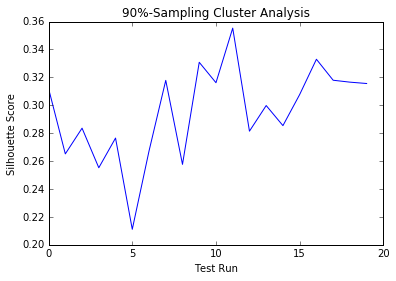

In [26]:
import matplotlib.pyplot as plt
sub_sample_score = sub_sample_study(data, 0.9, 20)
plt.plot(sub_sample_score)
plt.xlabel('Test Run')
plt.ylabel('Silhouette Score')
plt.title('90%-Sampling Cluster Analysis')


### Part 2: Add a random noise

In [27]:
def noise_analysis(dataset, epoch):
    start = 0
    result = []
    while start<epoch:
        noise_data = dataset.applymap(lambda x: x + np.random.rand()/25)
        noise_clusterer = mixture.GMM(n_components=2, random_state=0).fit(noise_data)
        noise_pred = noise_clusterer.predict(noise_data)
        noise_centers = noise_clusterer.means_
        noise_score = sc(noise_data, noise_pred)
        result.append(noise_score)
        start += 1
    return result

In [28]:
noise_score = noise_analysis(data, 20)

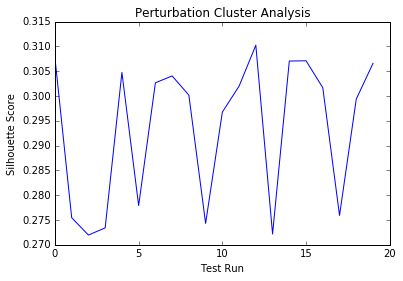

In [29]:
plt.plot(noise_score)
plt.xlabel('Test Run')
plt.ylabel('Silhouette Score')
plt.title('Perturbation Cluster Analysis')

## Justification

The benchmark clustering model is to cluster stocks based on their sectors. The silouette score of the benchmark model is calcualted as -0.0746.

In [67]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
data_label = [data_with_label.loc[name, 'SECTOR'] for name in data.index]
le.fit(data_label)
new_label = le.transform(data_label)
score_actual = sc(data, new_label)
print "Benchmark Silhoutte Score", score_actual

# reduced_data_w_label = reduced_data.copy()
# reduced_data_w_label['Label'] = pd.Series(new_label, index=reduced_data_w_label.index)
# real_centers = np.array(reduced_data_w_label.groupby(reduced_data_w_label['Label']).mean())
# print reduced_data_w_label.groupby(reduced_data_w_label['Label']).count()

Benchmark Silhoutte Score -0.0746273194062


# Part V. Conclusion

## Free-Form Visualization

To understand why the benchmark model performs a lot worse than the final model, we can visulize the results of the benchmark model on a reduced dataset (from PCA). The result is shown as below:

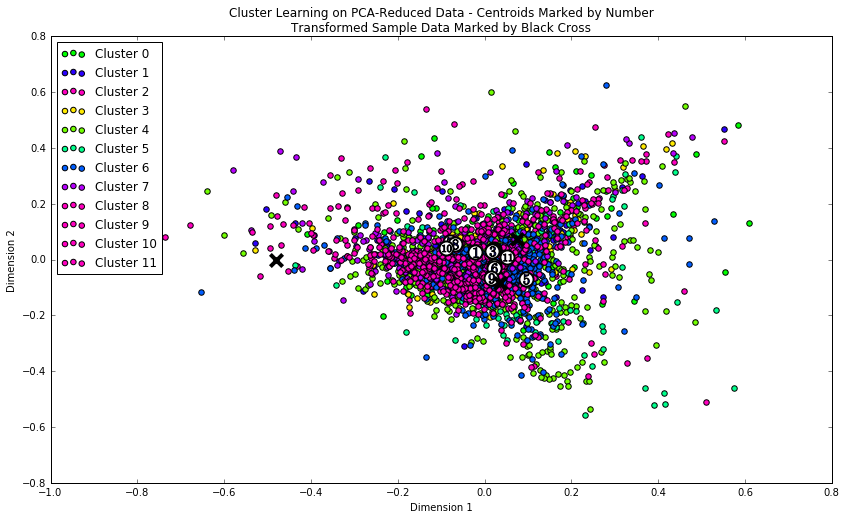

In [23]:
# Display the results of the clustering from implementationb
vs.cluster_results(reduced_data, new_label, real_centers, pca_samples)

The performance of the final K-Means model on the reduced dataset is shown below:

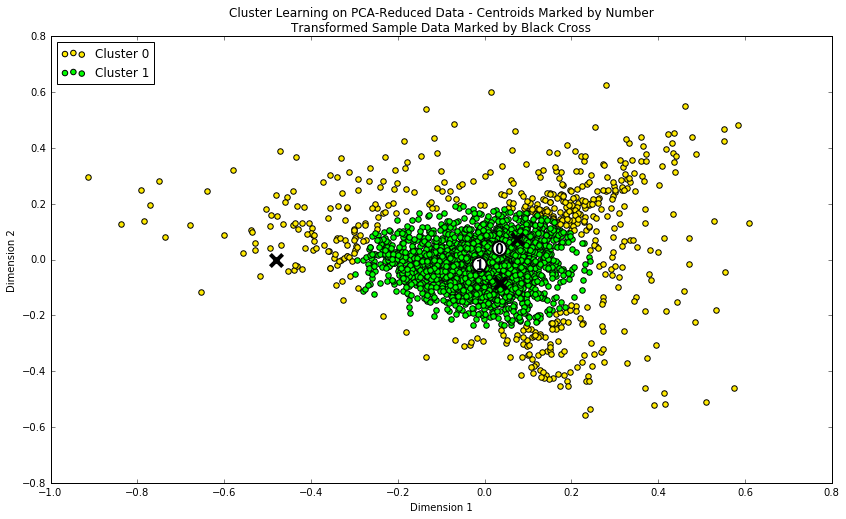

In [30]:
clusterer_final = mixture.GMM(n_components=2, random_state=0).fit(reduced_data)
preds_final = clusterer_final.predict(reduced_data)
centers_final = clusterer_final.means_
sample_preds2 = clusterer_final.predict(pca_samples)
score2 = sc(reduced_data, preds2)

# Display the results of the clustering from implementation
vs.cluster_results(reduced_data, preds_final, centers_final, pca_samples)

## Reflection

A summary of the work flow of this project is shown below:

1. Defined a problem and a benchmark solution.
2. Scraped a relevant dataset from web.
2. The dataset was examined for potential preprocessing needs.
3. Preprocessed the data including outlier removal and feature normalization.
4. Quantified feature relevance by studying the correlations between them.
5. Transformed features using PCA and examined the transformed features and variation they explained. The PCA was not able to reduce the dataset into 2 or 3 dimensions while keeping reasonable amount of variation, therefore, it's used as tool to visualize the dataset by reducing it to 2 dimensions.
6. Clustered the reduced and the original dataset by using K-Means and Gaussian Mixture. Refined the models by determining the number of clusters that yield the best silhouette score. Select a final model that best clustered the dataset.
7. Compared the final model to the benchmark model.

The interesting part of this project is applying feature scaling prior to PCA analysis. I started the project without scaling any features, and found a lot of the variation was lost after dimensionality reduction by PCA. The most significant dimension would always be the feature with the largest range of values, such as PE, eclipsing other features. I tried to scale the dataset in many different ways, and get drastically different results. Feature scaling became the most crucial and difficult part of the entire project as it will influence every following step. The eventual method for scaling the feature is to normalize all the data in the range from 0 to 1. The reason is that many features are percentage value (such as DY, SR, PCYL, PCYH), and have already been in that range. Scale all the features into that range will eliminate the impact of absolute value, and emphasize the impact of variability. 

The final model and solution does fit my expectation to a limited extent, as it is able to group stocks that are similar to each other in terms of the 8 features selected much better than the benchmark model is. However, due to the dataset itself may not be so separable, or the absence of observable clusters existing within the dataset, the model may have some limitations. 


## Improvement

To find potential improvement, we need to understand the limitations of this study. The foremost important factor is dataset. In this project, only eight features are selected to represent a stock. This representation is by no means comprehensive. In reality, a stock could have hundreds of features from technical, financial and other perspectives. How to select a representative feature space is beyond the scope of this project. However, if a more relevant and informative feature space can be determined, the clustering algorithms may yield more interesting results.

On the algorithm side, only two clustering algorithms have been explored, K-Means and Gaussian Mixture. They are centroid based and distribution based clustering algorithms respectively. There are also connectivity based and density based algorithms. Depends on the dataset and distribution, any of the clustering algorithms could be more appropriate than the others. Therefore, carefully select an algorithm based on the properties of the dataset could potentially improve the performance.
